In [157]:
import pandas
import matplotlib.pyplot as pyplot
import numpy
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Read in the data
calendar_dataframe = pandas.read_csv('./calendar.csv')
listings_dataframe = pandas.read_csv('./listings.csv')

The third question was to see if an ML model could be built to predict a price. Review the data that was loaded in.

In [158]:
calendar_dataframe.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [159]:
listings_dataframe.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


First thing...clean and setup the data in the dataframes as needed

In [160]:
# Convert the listing id to a string so that the data type is an object as it will be used a categorical variable
calendar_dataframe['listing_id'] = calendar_dataframe['listing_id'].astype(str)

# Impute NaN prices with the string $0.00, and then remove any dollar symbols so all prices are quantitative
calendar_dataframe['price'].fillna('$0.00', inplace=True)
calendar_dataframe['price'] = calendar_dataframe['price'].str.replace('[\$,]', '', regex=True).astype(float)

# Check the calendar dataframe rows and data types
calendar_dataframe.head(), calendar_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   listing_id  1393570 non-null  object 
 1   date        1393570 non-null  object 
 2   available   1393570 non-null  object 
 3   price       1393570 non-null  float64
dtypes: float64(1), object(3)
memory usage: 42.5+ MB


(  listing_id        date available  price
 0     241032  2016-01-04         t   85.0
 1     241032  2016-01-05         t   85.0
 2     241032  2016-01-06         f    0.0
 3     241032  2016-01-07         f    0.0
 4     241032  2016-01-08         f    0.0,
 None)

Store the quantitative columns from the listings dataframe in a new dataframe

In [161]:
# Stores these so that they can be used to set up the prediction variable
quantitative_columns = ['id', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'instant_bookable']

listings_dataframe_quantitative = listings_dataframe[quantitative_columns].copy()

# Convert the id to a string so that the data type is an object as it will be used a categorical variable
listings_dataframe_quantitative['id'] = listings_dataframe_quantitative['id'].astype(str)

# Remove any dollar symbols so all prices are quantitative
listings_dataframe_quantitative['price'].fillna('$0.00', inplace=True)
listings_dataframe_quantitative['price'] = listings_dataframe_quantitative['price'].str.replace('[\$,]', '', regex=True).astype(float)

# Check which quantities have null values
listings_dataframe_quantitative.isnull().sum()

id                        0
accommodates              0
bathrooms                16
bedrooms                  6
beds                      1
price                     0
minimum_nights            0
number_of_reviews         0
review_scores_rating    647
instant_bookable          0
dtype: int64

Get the rows with null values and loop through them imputing the column NaN values with 0

In [124]:
null_rows = listings_dataframe_quantitative.isnull().sum()

for index, value in null_rows.items():
    if value > 0:
        listings_dataframe_quantitative[index].fillna(0, inplace=True)

# Verify there are no more NaN values in the columns
listings_dataframe_quantitative.isnull().sum()

id                      0
accommodates            0
bathrooms               0
bedrooms                0
beds                    0
price                   0
minimum_nights          0
number_of_reviews       0
review_scores_rating    0
instant_bookable        0
dtype: int64

Check the quantitative dataframe before setting up the model

In [125]:
listings_dataframe_quantitative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3818 non-null   object 
 1   accommodates          3818 non-null   int64  
 2   bathrooms             3818 non-null   float64
 3   bedrooms              3818 non-null   float64
 4   beds                  3818 non-null   float64
 5   price                 3818 non-null   float64
 6   minimum_nights        3818 non-null   int64  
 7   number_of_reviews     3818 non-null   int64  
 8   review_scores_rating  3818 non-null   float64
 9   instant_bookable      3818 non-null   object 
dtypes: float64(5), int64(3), object(2)
memory usage: 298.4+ KB


Set up a linear regression model to predict listing prices

The instant_bookable column is categorical...convert f and t to 0 and 1 respectively...

In [126]:
listings_dataframe_quantitative['instant_bookable'] = listings_dataframe_quantitative.apply(
    lambda row: 1 if(row['instant_bookable'] == 't') else 0,
    axis=1
)

In [142]:
#Split into explanatory and response variables
training_columns = quantitative_columns.copy()
training_columns.remove('id')
training_columns.remove('price')

X = listings_dataframe_quantitative[training_columns].copy()
y = listings_dataframe_quantitative[['price']].copy()

X,y

(      accommodates  bathrooms  bedrooms  beds  minimum_nights  \
 0                4        1.0       1.0   1.0               1   
 1                4        1.0       1.0   1.0               2   
 2               11        4.5       5.0   7.0               4   
 3                3        1.0       0.0   2.0               1   
 4                6        2.0       3.0   3.0               1   
 ...            ...        ...       ...   ...             ...   
 3813             6        2.0       3.0   3.0               3   
 3814             4        1.0       1.0   2.0               2   
 3815             2        1.0       1.0   1.0               1   
 3816             2        1.0       0.0   1.0               3   
 3817             3        1.5       2.0   1.0               1   
 
       number_of_reviews  review_scores_rating  instant_bookable  
 0                   207                  95.0                 0  
 1                    43                  96.0                 0  
 2   

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, y_train)

# Get the predictions
y_train_predictions = pipe.predict(X_train)
y_test_predictions = pipe.predict(X_test)

# Get the scores
test_score = r2_score(y_test, y_test_predictions)
train_score = r2_score(y_train, y_train_predictions)

# Round the training and test predictions to 2 decimal places for comparisons
y_test_predictions_rounded = numpy.round(y_test_predictions,2)
y_train_predictions_rounded = numpy.round(y_train_predictions,2)

#Predict and score the model
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.4710103068356807.  The rsquared on the test data was 0.4029800883994943.


The rsquared scores are pretty low, but do not indicate there is an over fitting problem. This is a good starting point for the model, and it can be further refined from here. Combine the test and test predictions prices to see the difference.

In [148]:
actual_vs_predicted_prices = numpy.concatenate([y_test, y_test_predictions_rounded], axis=1)

actual_vs_predicted_prices

array([[349.  , 322.52],
       [ 55.  , 109.25],
       [100.  ,  81.28],
       ...,
       [ 85.  , 127.44],
       [135.  , 147.54],
       [200.  , 157.43]])

Graph the actual vs predicted prices. This shows a pretty solid consensus between the predicted and actual price of a listing.

Text(0.5, 1.0, 'Actual price (blue) vs Predicted price (orange)')

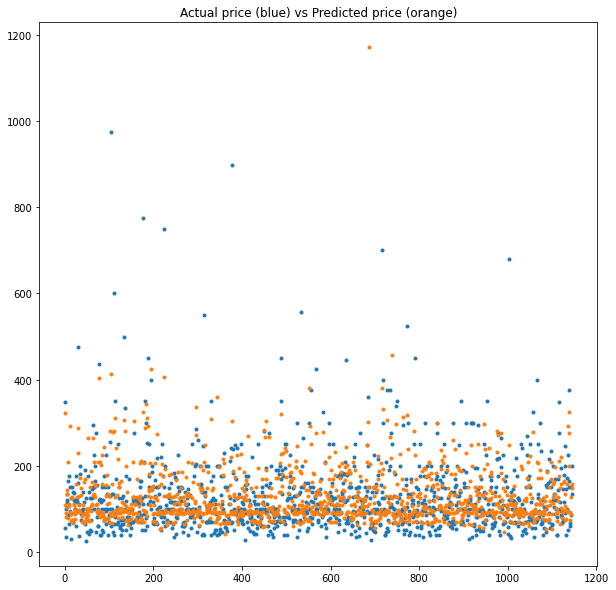

In [155]:
pyplot.figure(figsize=(10,10))
pyplot.plot(actual_vs_predicted_prices, marker = '.', linestyle = '')
pyplot.title('Actual price (orange) vs Predicted price (blue)')

Graph the deviation between the test data and the prediction data. Again a pretty flat line at 0.

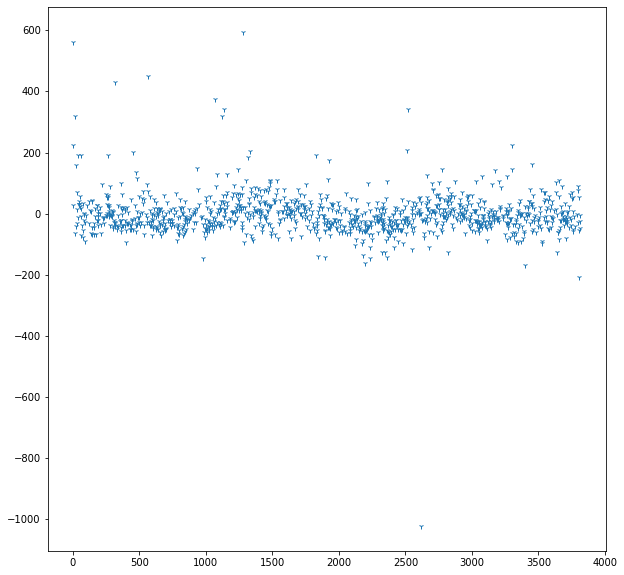

In [156]:
pyplot.figure(figsize=(10,10))
pyplot.plot(y_test - y_test_predictions_rounded, marker='1', linestyle='')

An option to make this model better would have been to impute 1 for beds, bedrooms and bathrooms since it's a good bet any listing on airbnb would have at least 1 of those. Or imputing with dummy data could improve this model as well.